<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Main-characters-network:" data-toc-modified-id="Main-characters-network:-1">Main characters network:</a></span></li><li><span><a href="#&quot;All-characters&quot;-network" data-toc-modified-id="&quot;All-characters&quot;-network-2">"All characters" network</a></span><ul class="toc-item"><li><span><a href="#Network-analysis:" data-toc-modified-id="Network-analysis:-2.1">Network analysis:</a></span></li><li><span><a href="#Network-analysis-and-statistics---all-seasons:" data-toc-modified-id="Network-analysis-and-statistics---all-seasons:-2.2">Network analysis and statistics - all seasons:</a></span></li><li><span><a href="#Some-pyvis-stuff-of-the--most-frequenct-characters:" data-toc-modified-id="Some-pyvis-stuff-of-the--most-frequenct-characters:-2.3">Some pyvis stuff of the  most frequenct characters:</a></span></li><li><span><a href="#Network-statistics---season-based:" data-toc-modified-id="Network-statistics---season-based:-2.4">Network statistics - season based:</a></span></li><li><span><a href="#Community-detection:" data-toc-modified-id="Community-detection:-2.5">Community detection:</a></span></li></ul></li></ul></div>

# Network analysis:

In [412]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
import networkx as nx
from fa2 import ForceAtlas2

import random

## Main characters network:

## "All characters" network

In [483]:
# Loading data:
df = pd.read_pickle('../data/Dataset_with_all_scene_characters.pkl')
df_names = pd.read_pickle('../data/Dataset_all_potential_characters.pkl')
all_Names = list(df_names[0])

In [484]:
l=list(np.unique(df.Episode))
seasons = []
seasons.append(l) # Season 0 = all episodes
seasons.append(l[9:10]+l[18:41])
seasons.append(l[41:64])
seasons.append(l[64:89])
seasons.append(l[89:112])
seasons.append(l[112:135])
seasons.append(l[135:158])
seasons.append(l[158:181])
seasons.append(l[181:204])
seasons.append(l[204:227])
seasons.append(l[0:9]+l[10:18])

In [485]:
ali = ['mon','mnca', 'chanlers', 'chan', 'joe', 'rach', 'phoebs','pheebs']
name = ['monica','monica','chandler','chandler','joey','rachel','phoebe','phoebe']
alias_dict = dict(zip(ali,name))

### Network analysis:

In [574]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.01,
                        strongGravityMode=True,
                        gravity=0.005,

                        # Log
                        verbose=False)

In [575]:
# Possible egdes between main characters:
main_links = []
char = ['monica','chandler','ross','rachel','phoebe','joey']
for c1 in char:
    for c2 in char:
        if c1!=c2: main_links.append((c1,c2))

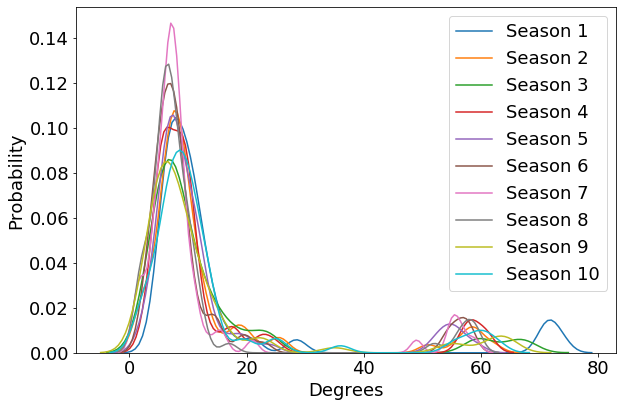

In [577]:
Nodes = {}
N_edges = {}
N_nodes = {}
N_degrees = {}
N_bi_char = {}

plot = False

if not plot: plt.figure(figsize=[9,6])

for s in list(range(1,len(seasons))) + [0]: #Loop end with network "0", ie. all seasons
    season = seasons[s]
    
    G = nx.Graph()
    for episode in season:
        df_season = df[df.Episode == episode].reset_index(drop = True)
        
        for i in range(len(df_season)):
            node1 = df_season.Speaker[i]
            try: 
                node1 = alias_dict[node1] 
            except:
                node1 = node1            
            
            for node2 in df_season.Scene_characters[i]:
                try: 
                    node2 = alias_dict[node2] 
                except:
                    node2 = node2
                
                if node1 in all_Names:
                    #add edges:
                    if (node1, node2) not in main_links:
                        if G.has_edge(node1, node2):
                            w = G[node1][node2]['weight']
                            G.add_edge(node1, node2, weight = w + 1)    
                        else:
                            G.add_edge(node1, node2, weight = 1)
        G.remove_edges_from(G.selfloop_edges())

    Nodes[s] = list(G.nodes())
    N_nodes[s] = G.number_of_nodes()
    N_edges[s] = G.number_of_edges()
    N_degrees[s] = list(G.degree(['rachel','ross','chandler','monica','joey','phoebe']))
    N_bi_char[s] = sorted(list(G.degree()), key = lambda x: x[1], reverse = True)[6:16]
    
    if plot and s>0:
        positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

        colors = dict(zip(list(G.nodes()),['lightblue']*len(G)))
        colors['monica'] = 'steelblue'; colors['rachel'] = 'steelblue'; colors['ross'] = 'steelblue'
        colors['chandler'] = 'steelblue'; colors['phoebe'] = 'steelblue'; colors['joey'] = 'steelblue'

        D = [list(G.degree)[i][1] for i in range(len(G))]
        node_size = [i/(1/max(D)) for i in D]

        W = list(nx.get_edge_attributes(G,'weight').values())
        edge_size = [i*(15/max(W))+0.5 for i in W] 

        labels = dict(zip(list(G.nodes()),list(G.nodes())))

        plt.figure(figsize=[15,10])

        nx.draw_networkx_nodes(G, positions, node_color = list(colors.values()), node_size=node_size, with_labels=True, alpha=0.7)
        edges = nx.draw_networkx_edges(G, positions, width = edge_size, edge_color='black', alpha=.7)
        nx.draw_networkx_labels(G, positions, labels ,font_size=20)

        plt.title('Season '+str(s), fontsize = 32)
        plt.axis('off')
        plt.tight_layout()

        plt.savefig('../figures/S'+str(s)+'network.png')
    elif s>0:
        plt.rcParams.update({'font.size': 18})
        sns.kdeplot(list(dict(G.degree()).values()), label = 'Season ' + str(s))

if not plot:
    plt.xlabel('Degrees')
    plt.ylabel('Probability')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.savefig('../figures/Degree_dist.png')

### Network analysis and statistics - all seasons:

In [564]:
forceatlas2 = ForceAtlas2()
#                         # Behavior alternatives
#                         outboundAttractionDistribution=True,  # Dissuade hubs
#                         edgeWeightInfluence=0.8,
#                         # Performance
#                         jitterTolerance=0.0001,  # Tolerance
#                         barnesHutOptimize=True,
#                         barnesHutTheta=1.2,
#                         # Tuning
#                         scalingRatio=0.001,
#                         strongGravityMode=False,
#                         gravity=0.001,
#                         # Log
#                         verbose=False
# )
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 214.16it/s]


BarnesHut Approximation  took  1.59  seconds
Repulsion forces  took  6.87  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.33  seconds


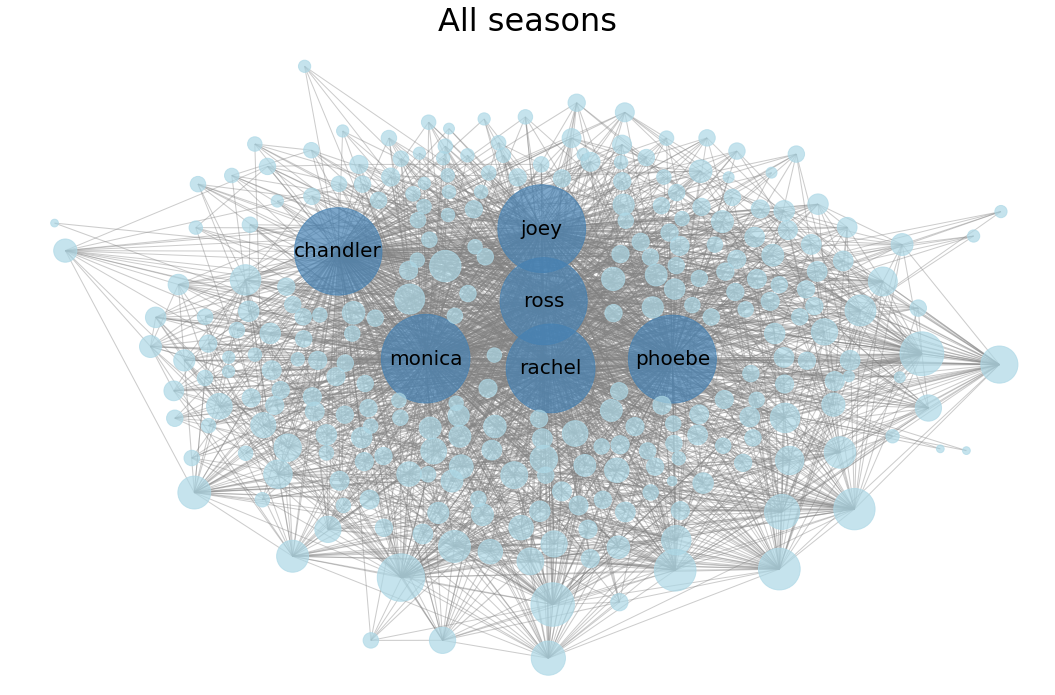

In [568]:
plt.figure(figsize=[15,10])

colors = dict(zip(list(G.nodes()),['lightblue']*len(G)))
colors['monica'] = 'steelblue'; colors['rachel'] = 'steelblue'; colors['ross'] = 'steelblue'
colors['chandler'] = 'steelblue'; colors['phoebe'] = 'steelblue'; colors['joey'] = 'steelblue'

D = [list(G.degree)[i][1] for i in range(len(G))]
node_size = [(x*30) for x in D]

W = list(nx.get_edge_attributes(G,'weight').values())
edge_size = [x**(1/5) for x in W]

nx.draw_networkx_nodes(G, positions, node_color = list(colors.values()), node_size=node_size, with_labels=True, alpha=0.7)
edges = nx.draw_networkx_edges(G, positions, width = edge_size, edge_color='gray', alpha=.4)

labels = dict(zip(list(G.nodes()),list(G.nodes())))
del labels['monica']; del labels['rachel']; del labels['ross']
del labels['chandler']; del labels['phoebe']; del labels['joey']
nx.draw_networkx_labels(G, positions, labels , font_size=12, font_color = 'k')

labels = dict(zip(['monica','rachel','ross','chandler','phoebe','joey'],['monica','rachel','ross','chandler','phoebe','joey']))
nx.draw_networkx_labels(G, positions, labels, font_size=20, font_color = 'k')

plt.title('All seasons',fontsize=32)
plt.axis('off')
plt.tight_layout()

# plt.savefig('../figures/All_seasons_network_no_labels.png')
# plt.savefig('../figures/All_seasons_network.png')

In [569]:
print(G.number_of_nodes())
print(G.number_of_edges())

276
2554


In [522]:
count_seasons = {}
for node in G.nodes():
    count_seasons[node] = 0
    for i in range(1,11):
        count_seasons[node] += Nodes[i].count(node)

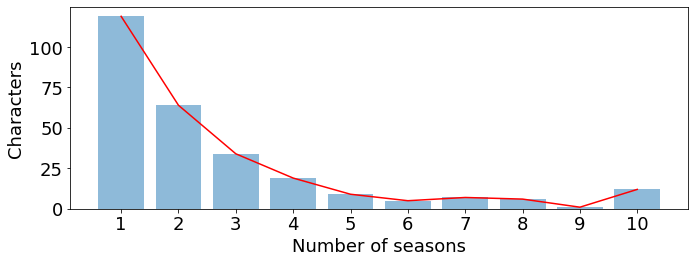

In [524]:
plt.figure(figsize=[10,4])
freqDist = nltk.FreqDist(list(count_seasons.values()))
xy = sorted(list(freqDist.items()), key=lambda kv: kv[0])
x = [x for x,y in xy]
y = [y for x,y in xy]
plt.plot(x,y,color = 'red');
plt.bar(x,y,alpha = 0.5);
plt.xlabel('Number of seasons');
plt.ylabel('Characters');
plt.xticks(list(range(1,11)),list(range(1,11)));
plt.tight_layout()
plt.savefig('../figures/Number_of_char_appearing_in_each_season.png')

In [525]:
second_main = dict([(k,v) for k,v in count_seasons.items() if v > 7])

### Some pyvis stuff of the  most frequenct characters:

In [526]:
from pyvis import network as net

In [561]:
plt.figure(figsize=[15,10])

nxg = G.subgraph(list(second_main.keys()))

colors = dict(zip(list(G.nodes()),['lightblue']*len(G)))
colors['monica'] = 'steelblue'; colors['rachel'] = 'steelblue'; colors['ross'] = 'steelblue'
colors['chandler'] = 'steelblue'; colors['phoebe'] = 'steelblue'; colors['joey'] = 'steelblue'

labels = dict(zip(list(G.nodes()),list(G.nodes())))

D = [list(G.degree)[i][1] for i in range(len(G))]
node_size = [x/8 for x in D]
node_size = dict( zip(list(G.nodes()),node_size ) )

W = list(nx.get_edge_attributes(G,'weight').values())
edge_size = [x**(1/5) for x in W]
edge_size = dict( zip(list(G.edges()),edge_size ) )

nx.set_node_attributes(nxg,colors,'color');
nx.set_node_attributes(nxg,labels,'label');
nx.set_node_attributes(nxg,node_size,'size');
nx.set_edge_attributes(nxg,edge_size,'weight');

G_plot = net.Network(width = '50%')
G_plot.force_atlas_2based(gravity=-150) 
# G_plot.hrepulsion(spring_length = 140)

for edge in nxg.edges(data=True):
    node1 = nxg.nodes(data=True)[edge[0]]
    node2 = nxg.nodes(data=True)[edge[1]]
    G_plot.add_node(edge[0], color = node1['color'], label = node1['label'], 
                    title = node1['label'], size = node1['size'])
    G_plot.add_node(edge[1], color = node2['color'], label = node2['label'], 
                    title = node2['label'], size = node2['size']) 
    G_plot.add_edge(edge[0], edge[1], weight=edge[2]['weight'],color='gray')

# G_plot.show_buttons(filter_=['physics'])
G_plot.save_graph("../_includes/All_seasons_frequent_char_network_interactive.html")

<Figure size 1080x720 with 0 Axes>

In [498]:
second_main_degree = [x for x,y in N_bi_char[0]] + ['rachel','ross','chandler','joey','phoebe','monica']

In [562]:
plt.figure(figsize=[15,10])

nxg = G.subgraph(second_main_degree)

colors = dict(zip(list(G.nodes()),['lightblue']*len(G)))
colors['monica'] = 'steelblue'; colors['rachel'] = 'steelblue'; colors['ross'] = 'steelblue'
colors['chandler'] = 'steelblue'; colors['phoebe'] = 'steelblue'; colors['joey'] = 'steelblue'

labels = dict(zip(list(G.nodes()),list(G.nodes())))

D = [list(G.degree)[i][1] for i in range(len(G))]
node_size = [x/8 for x in D]
node_size = dict( zip(list(G.nodes()),node_size ) )

W = list(nx.get_edge_attributes(G,'weight').values())
edge_size = [x**(1/5) for x in W]
edge_size = dict( zip(list(G.edges()),edge_size ) )

nx.set_node_attributes(nxg,colors,'color');
nx.set_node_attributes(nxg,labels,'label');
nx.set_node_attributes(nxg,node_size,'size');
nx.set_edge_attributes(nxg,edge_size,'weight');

G_plot = net.Network(width = '50%')
G_plot.force_atlas_2based(gravity=-150) 
# G_plot.hrepulsion(spring_length = 140)

for edge in nxg.edges(data=True):
    node1 = nxg.nodes(data=True)[edge[0]]
    node2 = nxg.nodes(data=True)[edge[1]]
    G_plot.add_node(edge[0], color = node1['color'], label = node1['label'], 
                    title = node1['label'], size = node1['size'])
    G_plot.add_node(edge[1], color = node2['color'], label = node2['label'], 
                    title = node2['label'], size = node2['size']) 
    G_plot.add_edge(edge[0], edge[1], weight=edge[2]['weight'],color='gray')

# G_plot.show_buttons(filter_=['physics'])
G_plot.save_graph("../_includes/All_seasons_degree_network_interactive.html")

<Figure size 1080x720 with 0 Axes>

### Network statistics - season based:

In [133]:
plt.rcParams.update({'font.size': 18})

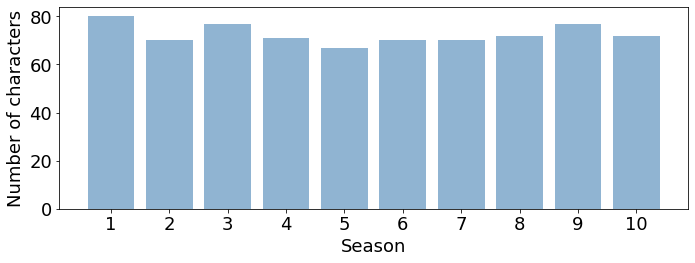

In [555]:
plt.figure(figsize = [10,4])
plt.bar(list(N_nodes.keys())[:10],list(N_nodes.values())[:10], color='steelblue',alpha = 0.6);
plt.xlabel('Season');
plt.xticks(list(N_nodes.keys())[:10],list(N_nodes.keys())[:10]);
plt.ylabel('Number of characters');
plt.tight_layout()
plt.savefig('../figures/total_number_of_nodes.png')

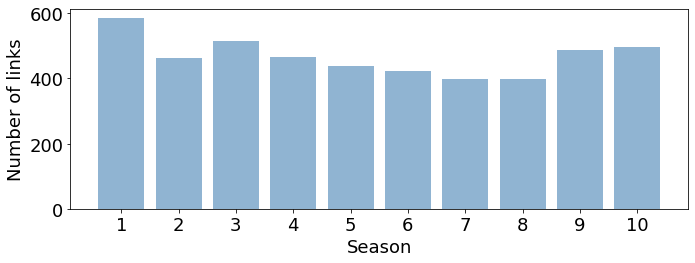

In [556]:
plt.figure(figsize = [10,4])
plt.bar(list(N_edges.keys())[:10],list(N_edges.values())[:10], color='steelblue',alpha = 0.6);
plt.xlabel('Season');
plt.xticks(list(N_edges.keys())[:10],list(N_edges.keys())[:10]);
plt.ylabel('Number of links');
plt.tight_layout()
plt.savefig('../figures/total_number_of_edges.png')

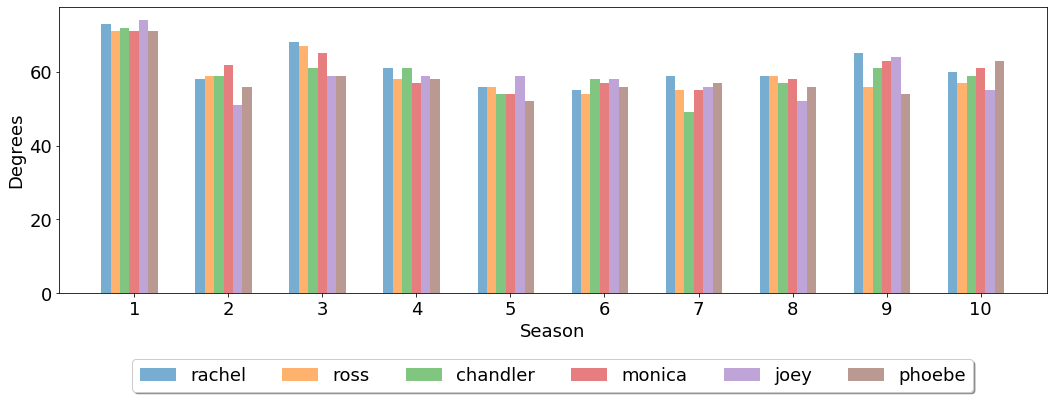

In [557]:
plt.figure(figsize = [15,6])

barwidth = 1/10
for c in range(6):
    x = np.array(range(1,11)) + (barwidth*c)
    D = [N_degrees[s][c][1] for s in range(1,11)]

    plt.bar(x, D,alpha = 0.6, width=barwidth);
    

names = [N_degrees[s][i][0] for i in range(6)]
plt.xticks(np.array(range(1,11))+3/10, list(range(1,11)))
plt.xlim([0.5,11])
plt.legend(names,
           loc='upper center', bbox_to_anchor=(0.5, -0.2),
           fancybox=True, shadow=True, ncol=6)
plt.xlabel('Season');
plt.ylabel('Degrees');
plt.tight_layout()
plt.savefig('../figures/season_degree_big_network.png')

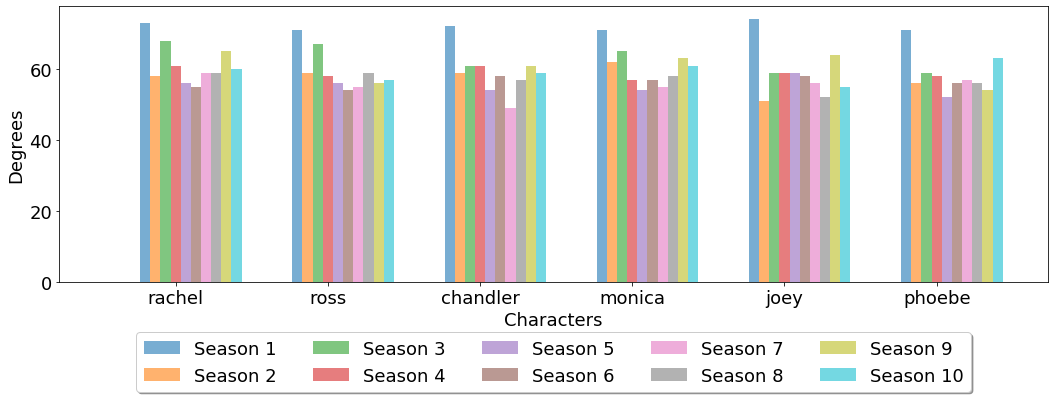

In [558]:
 plt.figure(figsize = [15,6])

barwidth = 1/15
for s in range(1,11):
    x = np.array(range(6)) + (barwidth*s)
    D = [N_degrees[s][c][1] for c in range(6)]

    plt.bar(x, D,alpha = 0.6, width=barwidth);
    

names = [N_degrees[s][i][0] for i in range(6)]
plt.xticks(np.array(range(6))+4/15, names)
plt.xlim([-0.5,6])
plt.legend(['Season 1','Season 2','Season 3','Season 4','Season 5','Season 6','Season 7','Season 8','Season 9','Season 10'],
           loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.xlabel('Characters');
plt.ylabel('Degrees');
plt.tight_layout()
plt.savefig('../figures/main_characters_degree_big_network.png')

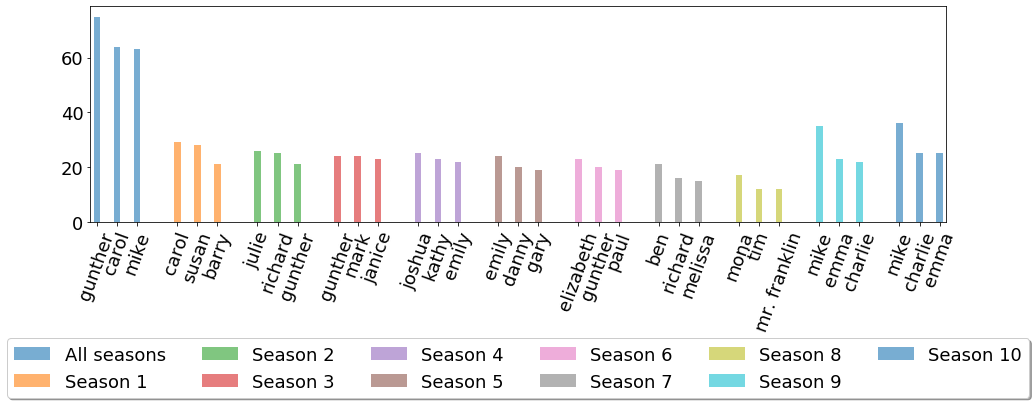

In [559]:
fig = plt.figure(figsize = [15,7.2])
ax = plt.subplot(111)
barwidth = 1

ticks_L = []
ticks_V = []

for s in range(11):
    x = np.array([0,3,6]) + (12*s)
    D = [N_bi_char[s][c][1] for c in range(3)]
    
    plt.bar(x, D, width = barwidth, alpha = 0.6);
    
    ticks_V.extend(x)
    ticks_L.extend([N_bi_char[s][c][0] for c in range(3)])

plt.xlim([-1,max(ticks_V)+1])
plt.legend(['All seasons','Season 1','Season 2','Season 3','Season 4','Season 5','Season 6','Season 7','Season 8','Season 9','Season 10'],
           loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=6)
plt.xticks(ticks_V,ticks_L, rotation=70)
plt.tight_layout()
plt.savefig('../figures/bi_characters_degree_big_network.png')

### Community detection: